In [1]:
# Import librairies
%matplotlib inline 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from timeit import default_timer as timers

In [2]:
path = "./kaggle/input/daily-sun-spot-data-1818-to-2019/"
filename = os.path.join(path,"sunspot_data.csv")
df = pd.read_csv('/kaggle/input/daily-sun-spot-data-1818-to-2019/sunspot_data.csv', delimiter=',', na_values=['-1'])
df.dataframeName = 'sunspot_data.csv'
del(df['Unnamed: 0'])
df.columns = ['year', 'month', 'day', 'fraction','sunspots', 'sdt', 'obs','indicator']
df.head(-5)
df['time']=df[['year', 'month', 'day']].apply(lambda s: pd.datetime(*s),axis = 1)
df.index = df['time']
df['sunspots'].interpolate(method='linear', inplace=True)

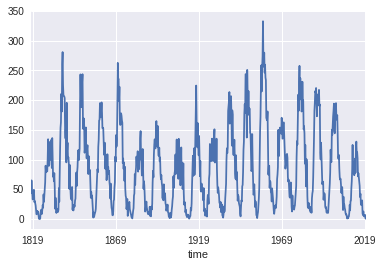

In [3]:
ts = pd.Series(data=df.sunspots, index=df.index)
ts_month = ts.resample('MS').mean()
ts_quarter = ts.resample('Q').mean()
ts_quarter.plot()
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller
def printADFTest(serie):
    result = adfuller(serie, autolag='AIC')
    print("ADF Statistic %F" % (result[0]))
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print('\n')

printADFTest(ts_quarter)

ADF Statistic -9.778954
p-value: 6.814515890287653e-17
Critial Values:
   1%, -3.4385918508847646
Critial Values:
   5%, -2.865177791819505
Critial Values:
   10%, -2.568707096601096




In [5]:
model = sm.tsa.statespace.SARIMAX(ts_quarter, trend='n', order=(3,0,10), seasonal_order=(1,1,0,43))
results = model.fit()
print(results.summary())

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                  Statespace Model Results                                 
Dep. Variable:                            sunspots   No. Observations:                  808
Model:             SARIMAX(3, 0, 10)x(1, 1, 0, 43)   Log Likelihood               -3584.094
Date:                             Fri, 13 Oct 2023   AIC                           7198.189
Time:                                     08:54:01   BIC                           7267.787
Sample:                                 03-31-1818   HQIC                          7224.982
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8983      0.130      6.925      0.000       0.644       1.153
ar.L2          0.7610      

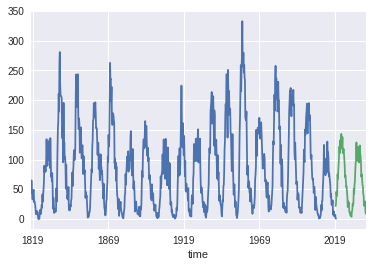

In [6]:
forecast = results.predict(start = ts_quarter.index[-2], end= ts_quarter.index[-2] + pd.DateOffset(months=240), dynamic= True) 
ts_quarter.plot()
forecast.plot()
plt.show()